In [313]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [314]:
def metricas(y_train, y_train_pred, y_test, y_test_pred):
    metricas = {
        'train': {
            'r2_score': r2_score(y_train, y_train_pred),
            'MAE': mean_absolute_error(y_train, y_train_pred),
            'MSE': mean_squared_error(y_train, y_train_pred),
            'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred))
        },
        'test': {
            'r2_score': r2_score(y_test, y_test_pred),
            'MAE': mean_absolute_error(y_test, y_test_pred),
            'MSE': mean_squared_error(y_test, y_test_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))

        }
    }
    return pd.DataFrame(metricas).T

In [315]:
df = pd.read_csv("datos/target_encoding.csv", index_col = 0)

In [316]:
X = df.drop("price", axis = 1)
y = df[["price"]]

In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## Decision Tree

In [318]:
np.set_printoptions(suppress= True)
# Parámetros a evaluar
params_arbol = {
    'max_depth': [14,15,16,17],
    'min_samples_split': [20,25,30,35],
    'min_samples_leaf': [20,30,40,50],
    'max_leaf_nodes': [650, 750, 850, 950]
}

In [319]:
grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, #cross validation
                                 scoring = "neg_mean_squared_error", #métrica que quiero medir
                                 n_jobs = -1) #use todos los núcleos del ordenador
grid_search_arbol.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [14, 15, 16, 17],
                         'max_leaf_nodes': [650, 750, 850, 950],
                         'min_samples_leaf': [20, 30, 40, 50],
                         'min_samples_split': [20, 25, 30, 35]},
             scoring='neg_mean_squared_error')

In [320]:
modelo_final_arbol = grid_search_arbol.best_estimator_
modelo_final_arbol

DecisionTreeRegressor(max_depth=17, max_leaf_nodes=950, min_samples_leaf=20,
                      min_samples_split=25)

In [ ]:
y_pred_test = modelo_final_arbol.predict(X_test)
y_pred_train = modelo_final_arbol.predict(X_train)

In [330]:
df_metricas_arbol = metricas(y_train, y_pred_train, y_test, y_pred_test)
df_metricas_arbol

,r2_score,MAE,MSE,RMSE
train,0.781478,1918.159760,1.002812e+07,3166.720922
test,0.765445,1957.161088,1.072099e+07,3274.292103


In [323]:
#plt.figure(figsize=(20,15))
#plot_tree(decision_tree= modelo_final_arbol,
#          feature_names= X.columns,
#          filled = True)

In [324]:
pd.DataFrame(grid_search_arbol.cv_results_).sort_values(by="rank_test_score", ascending=True).head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
241,0.509986,0.007458,0.006735,0.003218,17,950,20,25,"{'max_depth': 17, 'max_leaf_nodes': 950, 'min_...",-1.122410e+07,-1.136619e+07,-1.092003e+07,-1.138476e+07,-1.108249e+07,-1.119551e+07,175741.592462,1
242,0.492023,0.010183,0.006456,0.002072,17,950,20,30,"{'max_depth': 17, 'max_leaf_nodes': 950, 'min_...",-1.122410e+07,-1.136661e+07,-1.092003e+07,-1.138470e+07,-1.108249e+07,-1.119559e+07,175811.436757,2


In [325]:
df_resultados_arbol = pd.DataFrame(grid_search_arbol.cv_results_)
df_resultados_arbol_filtrado = df_resultados_arbol.filter(like="param").drop(columns = "params")
df_resultados_arbol_filtrado["MSE"] = df_resultados_arbol["mean_test_score"]
df_resultados_arbol_filtrado.head(2)

,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
0,14,650,20,20,-1.151366e+07
1,14,650,20,25,-1.151358e+07


In [326]:
df_rmse_prof = np.sqrt(df_resultados_arbol_filtrado.groupby("param_max_depth")["MSE"].mean().abs().reset_index())
df_rmse_prof

,param_max_depth,MSE
0,3.741657,3398.058830
1,3.872983,3392.863481
2,4.000000,3391.761304
3,4.123106,3391.921469


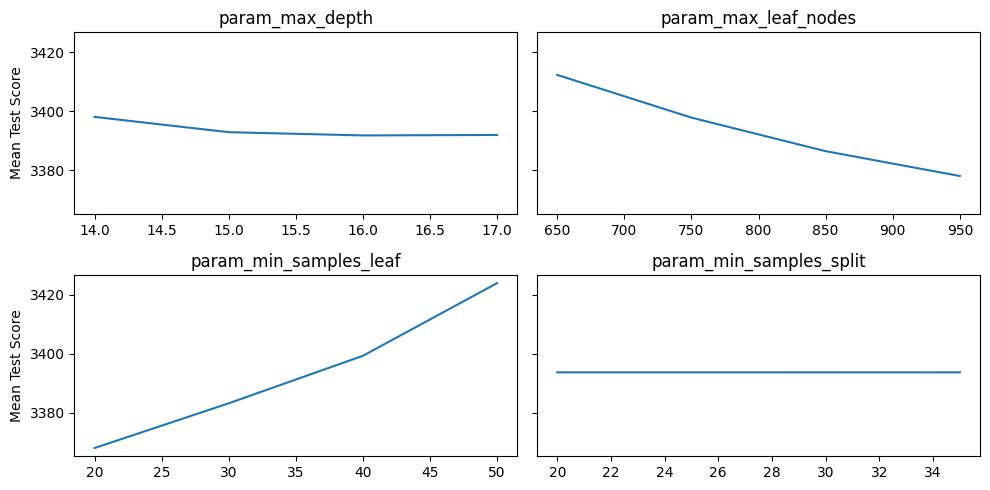

In [327]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), sharey=True)
axes = axes.flat

for indice, column in enumerate(df_resultados_arbol_filtrado.columns[:-1]):
    df_rmse_prof = (
        np.sqrt(df_resultados_arbol_filtrado.groupby(column)["MSE"].mean().abs())
        .reset_index()
    )
    
    sns.lineplot(
        x=df_rmse_prof[column],
        y=df_rmse_prof["MSE"],
        ax=axes[indice]    
    )
    
    axes[indice].set_title(f"{column}")
    axes[indice].set_xlabel("")
    axes[indice].set_ylabel("Mean Test Score")

plt.tight_layout()
plt.show()

In [328]:
pd.DataFrame(modelo_final_arbol.feature_importances_, columns= ["Importancia"], index=X.columns).sort_values(by="Importancia", ascending = False)

,Importancia
powerCV_robust,0.450543
kilometer_robust,0.319131
fuelType,0.077434
brand,0.058548
yearOfRegistration,0.044704
vehicleType,0.031337
notRepairedDamage,0.012409
gearbox,0.004117
monthOfRegistration,0.001551
abtest,0.000166
